
## Taller de Procesamiento de Señales - TP6 Bosques Aleatorios y Árboles de Decisión
### Alumno: Julián Stejman

--- 


Para este trabajo se utilizará un dataset de vinos y sus características. 

In [15]:
from sklearn.datasets import load_wine
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
import numpy as np

wine = load_wine()
X, y, feature_names, target_names = wine.data, wine.target, wine.feature_names, wine.target_names
print("Feature names:", feature_names)
print("Target names:", target_names)
print("Número de muestras:", X.shape[0])
print("Número de features:", X.shape[1])

Feature names: ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
Target names: ['class_0' 'class_1' 'class_2']
Número de muestras: 178
Número de features: 13


Se entrena un árbol de decisión utilizando a la entropía como criterio de impureza. Abajo se puede ver el criterio de decisión del árbol y que las 3 features más relevantes son color_intensity, flavanoids y proline.

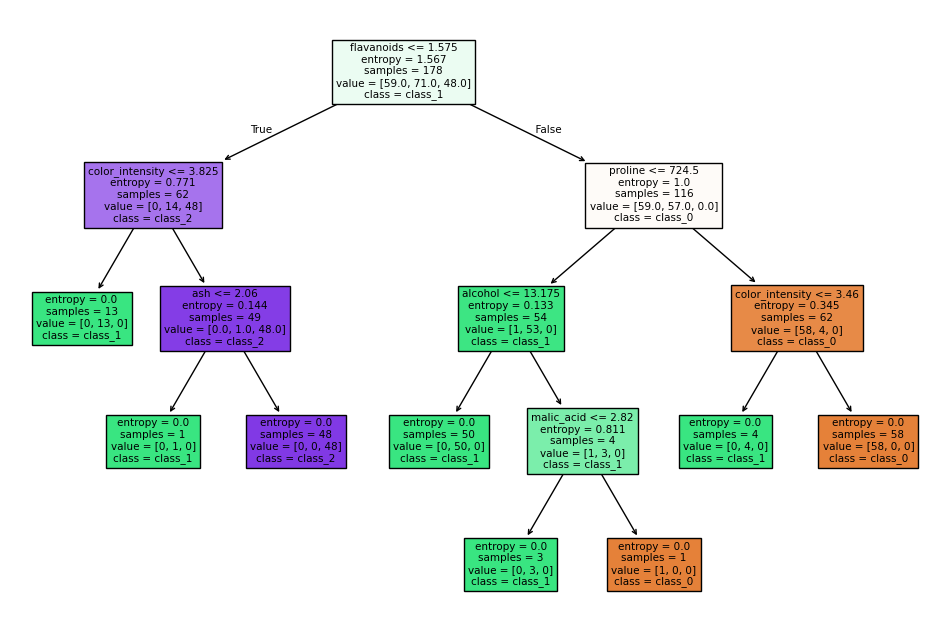

Las 3 features más relevantes son:
color_intensity: 0.2228
proline: 0.3134
flavanoids: 0.4128


In [16]:
clasificador = DecisionTreeClassifier(criterion='entropy')
clasificador.fit(X, y)

ax, fig = plt.subplots(figsize=(12, 8))
plot_tree(clasificador, filled=True, feature_names=feature_names, class_names=target_names)
plt.show()

# Busco los 3 features más relevantes
importances = clasificador.feature_importances_
indices = np.argsort(importances)[-3:]
print("Las 3 features más relevantes son:")
for i in indices:
    print(f"{feature_names[i]}: {importances[i]:.4f}")

Para la muestra que se da para analizar se identifica como de `class_0`

In [17]:
muestra_para_analizar = np.array([13, 2.33, 2.37, 19.5, 99.7, 2.29, 2.03, 0.36, 1.59, 5.06, 0.96, 2.61, 747])
prediccion = clasificador.predict([muestra_para_analizar])
print(f"Predicción para la muestra: {target_names[prediccion[0]]}")

Predicción para la muestra: class_0


Se genera otro clasificador pero con un $\alpha$ = 0.05. Se puede ver que el árbol tiene menos niveles haciendo que la clasificación fuera más corta.

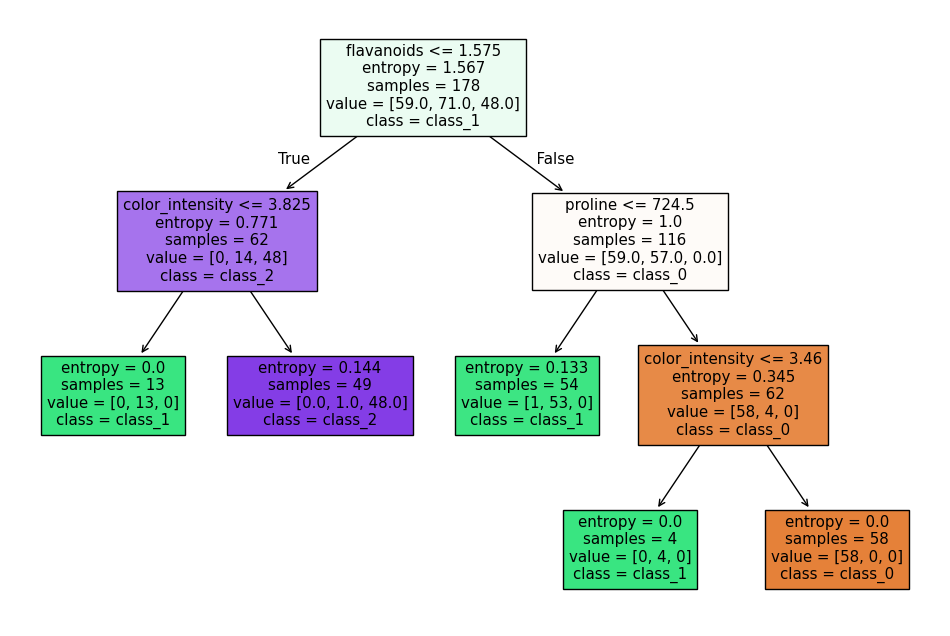

In [18]:
clasificador_podado = DecisionTreeClassifier(criterion='entropy', ccp_alpha=0.05)
clasificador_podado.fit(X, y)
ax, fig = plt.subplots(figsize=(12, 8))
plot_tree(clasificador_podado, filled=True, feature_names=feature_names, class_names=target_names)
plt.show()


Para calcular el costo-complejidad se halla el camino de costo-complejidad al podar al árbol. Luego se grafica para el $\alpha$ el valor de impureza. Para el valor elegido, se halla la impureza en un valor al rededor de 0.08.  

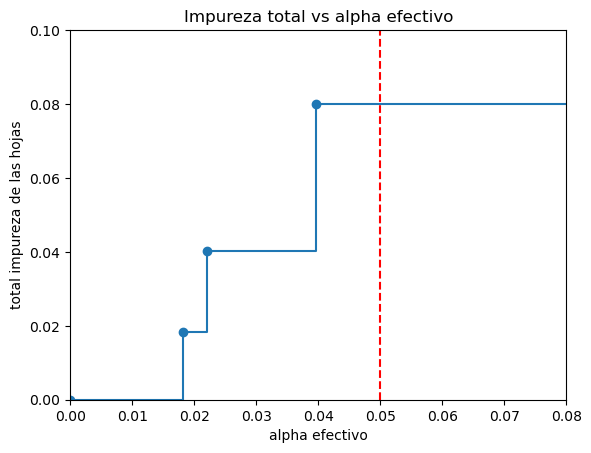

In [19]:
# Calculo el costo-complejidad 
path = clasificador.cost_complexity_pruning_path(X, y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("alpha efectivo")
ax.set_ylabel("total impureza de las hojas")
ax.set_title("Impureza total vs alpha efectivo")
ax.axvline(x=0.05, color='r', linestyle='--')
ax.set_xlim(0, 0.08)
ax.set_ylim(0, 0.1)
plt.show()

Se crea la clase de `BosqueAleatorio` cuya motivación es generar 30 árboles que tomen decisiones paralelamente y luego se tomara una "votación" entre todos los árboles para decidir adonde clasificar lo recibido. Para esto se eligen las muestras y etiquetas recibidas al azar para cada árbol, se selecciona un subconjunto de ellas y con eso se entrena algún k-ésimo árbol. 

In [20]:
class BosqueAleatorio:
    def __init__(self, n_trees = 30):
        self.n_trees = n_trees
        self.trees = []
    def fit(self, X, y):
        n_samples, n_features = X.shape
        for _ in range(self.n_trees):
            # Sampleo con reemplazo
            indices = np.random.choice(n_samples, n_samples, replace=True)
            X_sample = X[indices]
            y_sample = y[indices]
            # Selecciono un subconjunto de features
            feature_indices = np.random.choice(n_features, int(np.sqrt(n_features)), replace=False)
            X_sample = X_sample[:, feature_indices]
            # Entreno el árbol
            tree = DecisionTreeClassifier(criterion='entropy')
            tree.fit(X_sample, y_sample)
            # Almaceno el árbol
            self.trees.append((tree, feature_indices))
    def predict(self, X):
        # Hago la predicción de cada árbol
        predictions = np.zeros((X.shape[0], self.n_trees))
        for i, (tree, feature_indices) in enumerate(self.trees):
            X_sample = X[:, feature_indices]
            predictions[:, i] = tree.predict(X_sample)
        # Hago la votación
        return np.array([np.bincount(predictions[i].astype(int)).argmax() for i in range(predictions.shape[0])])

Se puede ver que mirando al árbol inicial, se sospecharía que la clase correcta para la muestra es la `class_0` pero luego de la votación de 30 árboles dentro del bosque aleatorio, se predice que la etiqueta correcta es la `class_1`

In [21]:
bosque = BosqueAleatorio(n_trees=30)
bosque.fit(X, y)
predicciones_bosque = bosque.predict(muestra_para_analizar.reshape(1, -1))
print(f"Predicción del bosque aleatorio para la muestra: {target_names[predicciones_bosque[0]]}")

Predicción del bosque aleatorio para la muestra: class_1
